<a href="https://colab.research.google.com/github/hamednasr/PyTorch/blob/main/red_wine_quality_sugar_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red Wine Quality
This is a PyTorch model to predict residual sugar.
https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats
import seaborn as sns

import pandas as pd
import time

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# Import and process the data

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
sugar = data['residual sugar']
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,5
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,5
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,6
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217380,0.401792,-0.980138,-0.380922,0.052836,1.547828,-0.068233,-0.982759,0.899027,-0.462207,0.074599,5
1595,-1.389638,0.122359,-0.877216,-0.237608,-0.542132,2.218623,0.151778,-0.865964,1.353377,0.599872,0.732539,6
1596,-1.159961,-0.101187,-0.722834,-0.165951,-0.244648,1.260344,-0.193954,-0.536815,0.704305,0.540868,0.544556,6
1597,-1.389638,0.653281,-0.774295,-0.380922,-0.265897,1.547828,-0.068233,-0.680154,1.677912,0.304850,-0.207376,5


In [ ]:
data.drop(columns=['residual sugar','quality'],inplace=True)

In [ ]:
data

,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.528350,0.960657,-1.391823,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307
1,-0.298673,1.966614,-1.391823,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341
2,-0.298673,1.295976,-1.185980,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341
3,1.653579,-1.386577,1.489975,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341
4,-0.528350,0.960657,-1.391823,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307
...,...,...,...,...,...,...,...,...,...,...
1594,-1.217380,0.401792,-0.980138,0.052836,1.547828,-0.068233,-0.982759,0.899027,-0.462207,0.074599
1595,-1.389638,0.122359,-0.877216,-0.542132,2.218623,0.151778,-0.865964,1.353377,0.599872,0.732539
1596,-1.159961,-0.101187,-0.722834,-0.244648,1.260344,-0.193954,-0.536815,0.704305,0.540868,0.544556
1597,-1.389638,0.653281,-0.774295,-0.265897,1.547828,-0.068233,-0.680154,1.677912,0.304850,-0.207376


# Convert data to tensor and train test split

In [ ]:
dataT  = torch.tensor( data.values ).float()
sugar = torch.tensor(sugar.values).float()

In [ ]:
sugar = sugar[:,None] 

In [ ]:
sugar.shape 

torch.Size([1597, 1])

In [ ]:
train_data,test_data, train_labels,test_labels = train_test_split(dataT, sugar, test_size=.1)

train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

In [ ]:
test_loader = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

train_loader = DataLoader(train_dataDataset,
                        batch_size=32, shuffle=True, drop_last=True)

# Model Creation

In [ ]:
class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(10,64)
    
    ### hidden layers
    self.fc1 = nn.Linear(64,128)
    self.fc2 = nn.Linear(128,32)

    ### output layer
    self.output = nn.Linear(32,1)
  
  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) ) # fully connected
    x = F.relu( self.fc2(x) )
    return self.output(x)

# Train the model

In [ ]:
numepochs = 1000

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.MSELoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.05)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      # batchAcc.append((((yHat-y).pow(2)).mean()).item())
    # end of batch loop...


    # now that we've trained through the batches, get their average training accuracy
    # trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
     # deactivates autograd
    with torch.no_grad():
      yHat = winenet(X)
      testAcc.append((lossfun(yHat,y).detach()).item())
  
  # function output
  return trainAcc,testAcc,losses

In [ ]:
winenet = ANNwine()
trainAcc,testAcc,losses = trainTheModel()

In [ ]:
train_corr = np.corrcoef(winenet(train_data).detach().squeeze(),train_labels.squeeze())[0,1]
test_corr = np.corrcoef(winenet(test_data).detach().squeeze(),test_labels.squeeze())[0,1]

# Model Evaluation

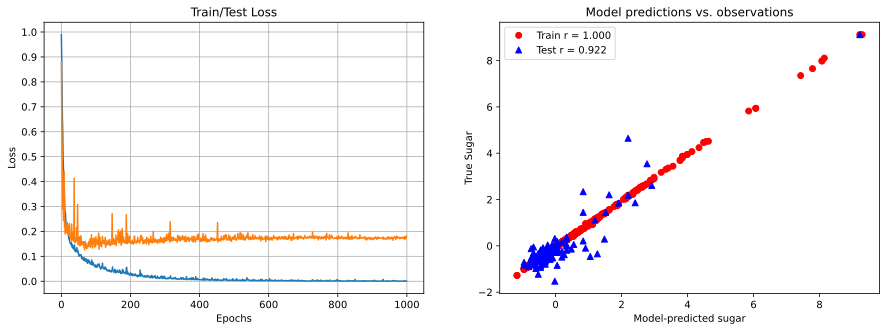

In [ ]:
# plot some results
fig, ax = plt.subplots (1, 2,figsize=(15,5))

ax[0].plot(losses)
ax[0].plot(testAcc)
ax[0].set_yticks(ticks=np.linspace(0,1,11))
ax[0].grid(True)  
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Train/Test Loss')

ax[1].plot(train_labels,winenet(train_data).detach(),'ro')
ax[1].plot(test_labels,winenet(test_data).detach(),'b^')
ax[1].set_ylabel('True Sugar')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_title('Model predictions vs. observations')
ax[1].legend([f'Train r = {format(train_corr,".3f")}',f'Test r = {format(test_corr,".3f")}'])

plt.show()


In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
data_corr = data.corr()

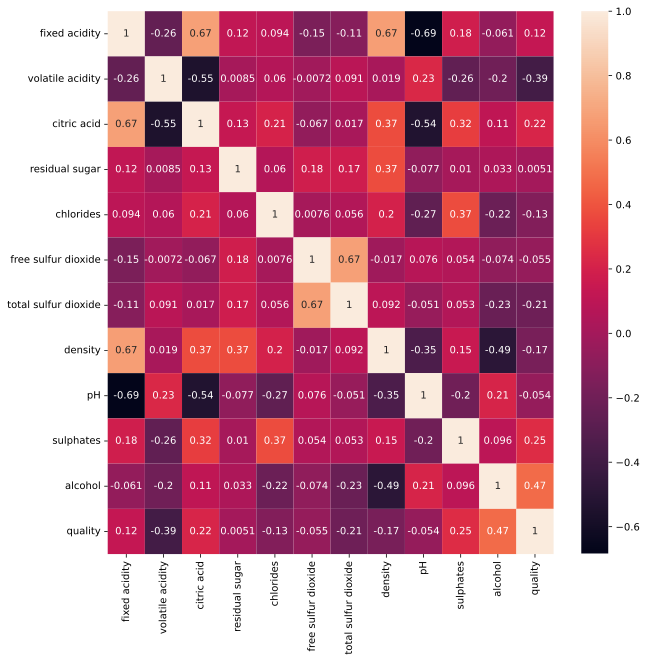

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(data_corr,annot=True)